## Objective:
#### To analyze  Google Merchandise Store (GStore)'s customer dataset to predict revenue per customer.

## Dataset:

#### Train and test datasets are provided. Each observation represents one visit to the store. The target that needs to be predicted is the natural log of the sum of all transactions per user. 

#### Evaluation = RMSE on ln(total_Revenue+1)

#### Features can generally take numeric, categorical, ordinal, datetime, coordinates and id(string) forms. In this dataset the features are as follows: 

* fullVisitorId- A unique identifier for each user of the Google Merchandise Store. (string)
* channelGrouping - The channel via which the user came to the Store. (categorical)
* date - The date on which the user visited the Store. (datetime)
* device - The specifications for the device used to access the Store. (categorical)
* geoNetwork - This section contains information about the geography of the user. (categorical.Coordinates not available)
* sessionId - A unique identifier for this visit to the store. (string)
* socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".(categorical(binary))
* totals - This section contains aggregate values across the session. (numeric)
* trafficSource - This section contains information about the Traffic Source from which the session originated.(categorical)
* visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.(string)
* visitNumber - The session number for this user. If this is the first session, then this is set to 1. (numeric)
* visitStartTime - The timestamp (expressed as POSIX time). (datetime)

### Libraries

In [107]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import datetime
%matplotlib inline
from scipy.stats import norm
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

### Feature Enginerring Functions

#### Some of the columns in the dataset are in JSON format and need to be converted to flat. 
#### According to the organizers, for the column 'trafficSource_adwordsClickInfo.isVideoAd', Null means  True. For the column 'trafficSource_isTrueDirect', missing values are False. 
#### 'visitStartTime'  expressed as POSIX time provides date and time of the visit.  It needs to be converted to datetime format.
#### The above issues has been addressed through the following functions.

In [108]:
cols_to_parse = ['device', 'geoNetwork', 'totals', 'trafficSource']
def read_parse_dataframe(file_name):
    #full path for the data file
    path = file_name
    #read the data file, convert the columns in the list of columns to parse using json loader,
    #convert the `fullVisitorId` field as a string
    data_df = pd.read_csv(path, 
        converters={column: json.loads for column in cols_to_parse}, 
        dtype={'fullVisitorId': 'str'})
    #parse the json-type columns
    for col in cols_to_parse:
        #each column became a dataset, with the columns the fields of the Json type object
        json_col_df = json_normalize(data_df[col])
        json_col_df.columns = [f"{col}_{sub_col}" for sub_col in json_col_df.columns]
        #we drop the object column processed and we add the columns created from the json fields
        data_df = data_df.drop(col, axis=1).merge(json_col_df, right_index=True, left_index=True)
    return data_df


def process_format(data_df):
    data_df['trafficSource_adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
    data_df['trafficSource_isTrueDirect'].fillna(False, inplace=True)
    return data_df
    
def process_visit_time(data_df):
    data_df["visitStartTime"] = data_df['visitStartTime'].apply(lambda x : datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    return data_df

## Data

In [109]:
%%time
train_df =read_parse_dataframe('../input/train.csv')
train_df = process_format(train_df)
test_df = read_parse_dataframe('../input/test.csv')
test_df = process_format(test_df)

CPU times: user 5min 14s, sys: 5.26 s, total: 5min 19s
Wall time: 5min 19s


In [110]:
train_df.shape

(903653, 55)

#### Train data includes 903653 rows (visits) and 55 features. 

In [111]:
test_df.shape

(804684, 53)

#### Test data includes 804684 rows (visits) and 53 features.

In [112]:
feature_difference = set(train_df) - set(test_df)
print(feature_difference)

{'trafficSource_campaignCode', 'totals_transactionRevenue'}


#### Two feaures are in the train dataset but not in the test dataset. One of them is the target variable and the other one is the campain code, a sub-category of the traffic source which includes only one not Null value and should be removed.

In [113]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserSize,device_browserVersion,device_deviceCategory,device_flashVersion,device_isMobile,device_language,device_mobileDeviceBranding,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_mobileDeviceModel,device_mobileInputSelector,device_operatingSystem,device_operatingSystemVersion,device_screenColors,device_screenResolution,geoNetwork_city,geoNetwork_cityId,geoNetwork_continent,geoNetwork_country,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_networkLocation,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_transactionRevenue,totals_visits,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,True,NaN,NaN,(not set),NaN,False,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,True,NaN,NaN,(not set),NaN,False,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,True,NaN,NaN,(not set),NaN,False,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,Fa

### Constant Features

#### There are some features that only include one variable. These features do not add any value to the model and must be removed. 

In [114]:
cols_to_drop = [col for col in train_df.columns if train_df[col].nunique(dropna=False) == 1]
train_df.drop(cols_to_drop, axis=1, inplace=True)
test_df.drop([col for col in cols_to_drop if col in test_df.columns], axis=1, inplace=True)

In [115]:
# Only one not Null value
train_df.drop(['trafficSource_campaignCode'], axis=1, inplace=True)

#### The session id does not provide any new information. Therefore it is removed. 

In [116]:
train_df.drop(['sessionId'], axis=1, inplace=True)
test_df.drop(['sessionId'], axis=1, inplace=True)

###  Target Variable (Revenue)

#### The target ,  'totals_transactionRevenue',   has the transaction value for each visit. However, the train set has 98.72% of missing values for revenue which according to the organizers need to be considered as zero revenue (no purchase) . The revenue unit is million USD (10^6).

In [117]:
non_missing = len(train_df[~train_df['totals_transactionRevenue'].isnull()])
num_visitors = train_df[~train_df['totals_transactionRevenue'].isnull()]['fullVisitorId'].nunique()
print("totals_transactionRevenue has {} non-missing values or {:.3f}% (train set)"
      .format(non_missing, 100*non_missing/len(train_df)))
print("Only {} unique users have transactions or {:.3f}% (train set)"
      .format(num_visitors, num_visitors/train_df['fullVisitorId'].nunique()))

totals_transactionRevenue has 11515 non-missing values or 1.274% (train set)
Only 9996 unique users have transactions or 0.014% (train set)


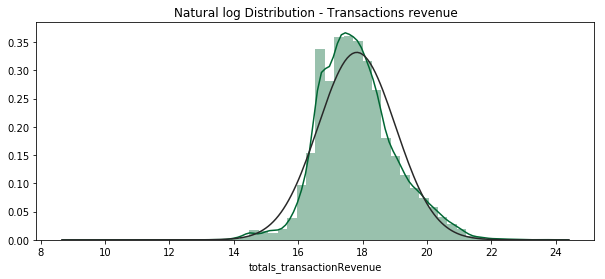

In [118]:
revenue = train_df['totals_transactionRevenue'].dropna().astype('float64')
plt.figure(figsize=(10,4))
plt.title("Natural log Distribution - Transactions revenue")
ax1 = sns.distplot(np.log1p(revenue), color="#006633", fit=norm)

#### The log of total transaction revenue per visit approximately follows a normal distribution.  Therefore, the mean, the median and the mode can be used as  measures of central tendency.

In [119]:
train_df['totals_transactionRevenue'] = train_df['totals_transactionRevenue'].fillna(0).astype('int64')

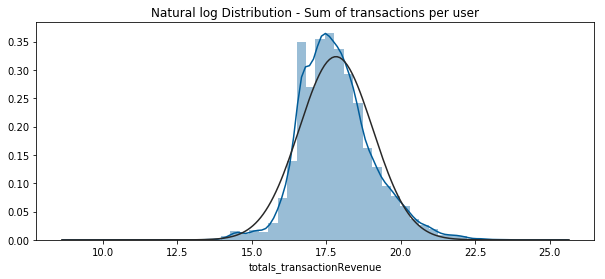

In [120]:
g = train_df[train_df['totals_transactionRevenue'] > 0][['fullVisitorId', 'totals_transactionRevenue']]
sum_transactions = g.groupby('fullVisitorId')['totals_transactionRevenue'].sum()
plt.figure(figsize=(10,4))
plt.title("Natural log Distribution - Sum of transactions per user")
ax1 = sns.distplot(np.log1p(sum_transactions), color="#005c99", fit=norm)

#### The Natural log of the sum of non_zero transactions per unique user (target) followes a normal disrtibution. 

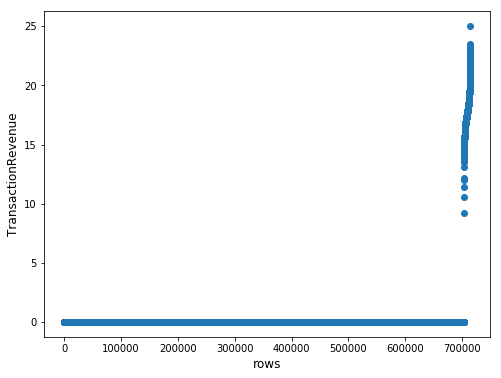

In [121]:
gdf = train_df.groupby("fullVisitorId")["totals_transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals_transactionRevenue"].values)))
plt.xlabel('rows', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

#### In business, the 80-20 rule is used to explain that 80% of a company's revenue is generated by 20% of its total customers. It could help in determining which operating factors are most important and should receive the most attention based on an efficient use of resources. The above graph illustrates that the Pareto principle applies in our case study. Therefore predicting the revenue generating customers as the result of this study can be greatly helpful to the buisiness.

## EDA

### Train and Test set Exploration

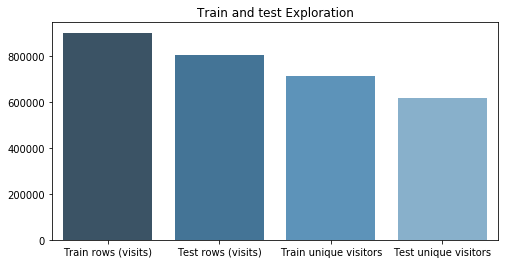

In [122]:
values_name = ['Train rows (visits)', 'Test rows (visits)', 'Train unique visitors', 'Test unique visitors']
values = [len(train_df), len(test_df), train_df['fullVisitorId'].nunique(), test_df['fullVisitorId'].nunique()]
plt.figure(figsize=(8,4))
plt.title("Train and test Exploration")
ax = sns.barplot(x=values_name, y=values, palette='Blues_d')

In [123]:
nzv = train_df["totals_transactionRevenue"].sum()
nzr = (gdf["totals_transactionRevenue"]>0).sum()
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gdf.shape[0])

Number of unique customers with non-zero revenue :  9996 and the ratio is :  0.013996726255903731


In [124]:
print("Number of unique visitors in train set : ",train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])
print("Number of unique visitors in test set : ",test_df.fullVisitorId.nunique(), " out of rows : ",test_df.shape[0])
print("Number of common visitors in train and test set : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))
A= set(train_df.fullVisitorId)
B= set(test_df.fullVisitorId)
common = A.intersection(B)


Number of unique visitors in train set :  714167  out of rows :  903653
Number of unique visitors in test set :  617242  out of rows :  804684
Number of common visitors in train and test set :  7679


#### 7679 customers are in both train and test datasets. Common ids need to be taken out of the train set to avoide leakage.

### Timeseries

#### In this section, date of each visit has been  converted to the datetime format.  Month and day of each visit have been extracted to allow further visualization.

In [125]:
train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
test_df['date'] = test_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))

In [126]:
train_df["date"] = pd.to_datetime(train_df["date"])
train_df["month"]  = train_df['date'].dt.month
train_df["day"]  = train_df['date'].dt.day
test_df["date"] = pd.to_datetime(test_df["date"])
test_df["month"]  = test_df['date'].dt.month
test_df["day"]  = test_df['date'].dt.day

#### In this setion, visit date including (year, month and day) is used to illusterate the number of visits to GStore and the sum of the total revenue for each date. 

In [127]:
# Visits by time train
tmp_train = train_df['date'].value_counts().to_frame().reset_index().sort_values('index')
tmp_train = tmp_train.rename(columns = {"date" : "visits"}).rename(columns = {"index" : "date"})

# Plot visits
trace1 = go.Scatter(x=tmp_train.date.astype(str), y=tmp_train.visits,
                    opacity = 0.8, line = dict(color = '#005289'), name= 'Train')

traces = [trace1]

layout = dict(
    title= "Visits by date",
    xaxis = dict(
        range = ['2016-08-01','2017-08-01'])
)

fig = dict(data= traces, layout=layout)
iplot(fig)


# Revenue by time
train_date_sum = train_df.groupby('date')['totals_transactionRevenue'].sum().to_frame().reset_index()
# Plot log revenue
trace_date = go.Scatter(x=train_date_sum.date.astype(str), 
                        y=train_date_sum['totals_transactionRevenue'].apply(lambda x: np.log1p(x)), opacity = 0.8)
layout = dict(
    title= "Log Revenue by date",
    xaxis = dict(
        range = ['2016-08-04','2017-08-01'])
)

fig = dict(data= [trace_date], layout=layout)
iplot(fig)

#### The above graphs indicate the followings:
* Train dataset contain data in the period of August 1st, 2016 to July 31st 2017. So the data is collected for one year.
* Test data ranges from August 1st, 2017 to April 30th, 2018
* There are some peaks and falls in number of visits and the sum of revenue that could be examined further.

In [128]:
colors = ["#8d44fc", "#ed95d5", "#caadf7", "#6161b7", "#7e7eba", "#babad1"]
fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["Visits by Month", "Visits by Day"], print_grid=False)
trs = []
for i,col in enumerate(["month", "day"]):
    t = train_df[col].value_counts()
    tr = go.Bar(x = t.index, marker=dict(color=colors[i]), y = t.values)
    trs.append(tr)

fig.append_trace(trs[0], 1, 1)
fig.append_trace(trs[1], 1, 2)
fig['layout'].update(height=400, showlegend=False)
iplot(fig)

#### The above graphs show that the number of visits was highest in November followed by October.  February had the least number of visits in train dataset.  The number of visits seem to be less related to the day of the month. However, it shows a little decrease during the last days of month. Next we will explore whether this pattern exists for the revenue generating visits.

In [129]:
tmp1 = train_df.groupby('month').agg({"totals_transactionRevenue" : "mean"}).reset_index()
tmp2 = train_df.groupby('day').agg({"totals_transactionRevenue" : "mean"}).reset_index()

fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["Mean of Revenue by Month", "Mean of Revenue by Day"], print_grid=False)
tr1 = go.Bar(x = tmp1.month, marker=dict(color="red", opacity=0.5), y = tmp1.totals_transactionRevenue)
tr2 = go.Bar(x = tmp2.day, marker=dict(color="orange", opacity=0.5), y = tmp2.totals_transactionRevenue)

fig.append_trace(tr1, 1, 1)
fig.append_trace(tr2, 1, 2)
fig['layout'].update(height=400, showlegend=False)
iplot(fig)

tmp3 = train_df.groupby('month').agg({"totals_transactionRevenue" : "sum"}).reset_index()
tmp4 = train_df.groupby('day').agg({"totals_transactionRevenue" : "sum"}).reset_index()

fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["Sum of Revenue by Month", "Sum of Revenue by Day"], print_grid=False)
tr3 = go.Bar(x = tmp3.month, marker=dict(color="blue", opacity=0.5), y = tmp3.totals_transactionRevenue)
tr4 = go.Bar(x = tmp4.day, marker=dict(color="green", opacity=0.5), y = tmp4.totals_transactionRevenue)

fig.append_trace(tr3, 1, 1)
fig.append_trace(tr4, 1, 2)
fig['layout'].update(height=400, showlegend=False)
iplot(fig)

#### The above figures show that the number visits and the amount of revenue do not follow the same pattern. The number of visits have been high or low during different months and it hes been reflected in the mean of revenue.  However, no relation can be observed comparing the sum of revenue at the number of visits for each month.  The day of month pattern of visits and revenue generating visits  do not provide a clear image. Looking at holidays and weekends or the dates of campains  in relation to these variables could be helpful in extracting the pattern. 

### Channels and Visits

In [130]:
def barplot_percentage(count_feat, color1= 'rgb(26, 118, 255)', color2='rgb(102, 204, 153)',
                       num_bars= None):

    train_channel = 100*train_df[count_feat].value_counts()/len(train_df)
    train_channel = train_channel.to_frame().reset_index()
    
    if num_bars:
        train_channel = train_channel.head(num_bars)
        
    trace0 = go.Bar(
        x=train_channel['index'],
        y=train_channel[count_feat],
        name='Train set',
        marker=dict(color=color1)
    )
    
    
    layout = go.Layout(
        title='{}'.format(count_feat),
        xaxis=dict(
            tickfont=dict(size=14, color='rgb(107, 107, 107)')
        ),
        yaxis=dict(
            title='Percentage of visits',
            titlefont=dict(size=16, color='rgb(107, 107, 107)'),
            tickfont=dict(size=14, color='rgb(107, 107, 107)')
        ),
        legend=dict(
            x=1.0,
            y=1.0,
            bgcolor='rgba(255, 255, 255, 0)',
            bordercolor='rgba(255, 255, 255, 0)'
        ),
        barmode='group',
        bargap=0.15,
        bargroupgap=0.1
    )

    fig = go.Figure(data=[trace0], layout=layout)
    iplot(fig)
barplot_percentage('channelGrouping')

 #### Organic Research followed by Social are responsible for the most visits to the website.

### Channels and Revenue Generating Visits

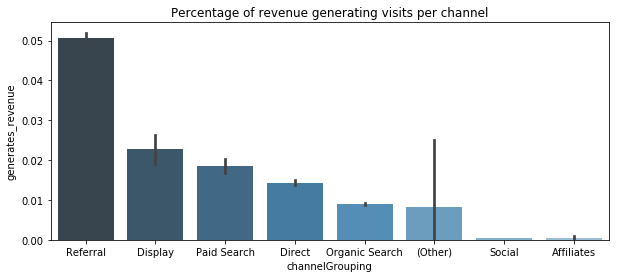

In [131]:
train_df['generates_revenue'] = train_df['totals_transactionRevenue'].apply(lambda x: 1 if x > 0 else 0)
channel_order = ['Referral', 'Display', 'Paid Search', 'Direct', 'Organic Search', '(Other)', 'Social', 'Affiliates']
plt.figure(figsize=(10,4))
plt.title("Percentage of revenue generating visits per channel")
sns.barplot(x='channelGrouping', y='generates_revenue', data=train_df, order=channel_order, palette='Blues_d')
plt.show()

#### Revenue generating visits do not follow the same pattern as all the visits. In fact Organic Search and Social are among the least revenue generating channels. Referral followed by Display and Paid Search are the top 3 revenue generating channels.

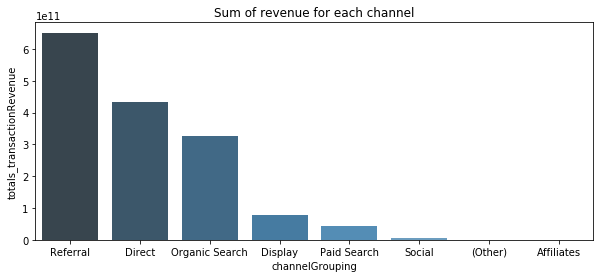

In [132]:
revenue_channel = train_df.groupby('channelGrouping')['totals_transactionRevenue'].sum()
revenue_channel = revenue_channel.to_frame().reset_index()
channel_order2 = ['Referral','Direct', 'Organic Search','Display', 'Paid Search',  'Social','(Other)', 'Affiliates']
plt.figure(figsize=(10,4))
plt.title("Sum of revenue for each channel")
ax = sns.barplot(x='channelGrouping', y='totals_transactionRevenue', data=revenue_channel, order=channel_order2, palette='Blues_d')

#### Sum of the revenue for each chanel illustrate that Referral is still the channel which brings the highest amount of revenue. However, Organic Search and Direct which previously was shown to generate high number of visits, are in secound and third place in terms of sum of the  revenue generated. 

### Number of visits and generation of Revenue

In [133]:
train_df.visitNumber.describe()

count    903653.000000
mean          2.264897
std           9.283735
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         395.000000
Name: visitNumber, dtype: float64

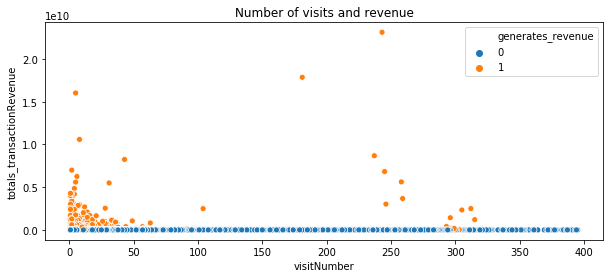

In [134]:
plt.figure(figsize=(10,4))
plt.title("Number of visits and revenue")
ax = sns.scatterplot(x='visitNumber', y='totals_transactionRevenue',
                     data=train_df, hue='generates_revenue') 

#### Considering the above figure, we can conclude that the number of visits is not positively correlated with revenue generating visits. Most revenue generating visits took place with number of visits below 50 counts with the concentration among single digit visits. Some outliers and some clusters of users exist with high number of visits and a range of total transaction revenue.   Referral, the channel with the highest sum of revenue does not have the highest number of visits. However, the channels that have high number of visits (Organic Search and Direct) still are contributing greately  to the revenue.  This  pattern can confirm the 80/20 rull explaining that the most revenue generating customers could come to the GStore through Referral channel while those channels who attracts more visitors are responsible for the rest of revenue. 

### Geographic Data

In [135]:
def plotmap(frame, z_var, countries_col, title, colorscale, rcolor=True):

    data = [ dict(
            type = 'choropleth',
            autocolorscale = False,
            colorscale = colorscale,
            showscale = True,
            reversescale = rcolor,
            locations = frame[countries_col],
            z = frame[z_var],
            locationmode = 'country names',
            text = frame[countries_col],
            marker = dict(line = dict(color = '#fff', width = 2))
        )           
    ]

    layout = dict(
        height=680,
        title = title,
        geo = dict(
            showframe = False,
            showcoastlines = False,
            projection = dict(type = 'mercator'),
        ),
    )
    fig = dict(data=data, layout=layout)
    iplot(fig)

colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
        [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]]
# Plot world map - total visits
tmp = train_df["geoNetwork_country"].value_counts().to_frame().reset_index()
plotmap(tmp, 'geoNetwork_country', 'index', 'Total visits by Country', colorscale)

# Plot world map - total revenue
tmp = train_df.groupby("geoNetwork_country").agg({"totals_transactionRevenue" : "sum"}).reset_index()
plotmap(tmp, 'totals_transactionRevenue','geoNetwork_country', 'Total revenue by country', colorscale)

#### United States alone is responsible for the highest number of visits to the GStore and the sum of revenue generated. This fact will be used later in feature engineering of the variable of country as the binary variable of US or others. 

In [136]:
tmp1 = train_df["geoNetwork_continent"].value_counts().to_frame().reset_index()
tmp2 = train_df.groupby("geoNetwork_continent")["totals_transactionRevenue"].sum().to_frame().reset_index()
fig = {
  "data": [
    {
        "values": tmp1['geoNetwork_continent'],
        "labels": tmp1['index'],
        "name": "Visits",
        "domain": {"x": [0, 0.46]},
        "hoverinfo":"label+percent+name",
        "hole": .6,
        "type": "pie",
        
    },
    {
        "values": tmp2['totals_transactionRevenue'],
        "labels": tmp2['geoNetwork_continent'],
        "name": "Revenue",
        "domain": {"x": [.54, 1]},
        "hoverinfo":"label+percent+name",
        "hole": .6,
        "type": "pie",
        
    }],
      "layout": {
        "title":"Visits and Revenue by Continent",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Visits",
                "x": 0.18,
                "y": 0.5
            },
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Revenue",
                "x": 0.85,
                "y": 0.5
            }
        ]
    }
}
iplot(fig, filename='donut')

#### As it was established previously, the United States and as the result of that Americas are the revenue generating country and continent relatively. Asia with about 1% share in generating revenue sits at the secound.  Concerning about the most revenue generating customers, it seems continent feature can be removed. 

In [137]:
train_df['country'] = np.where(train_df['geoNetwork_country']=='United States', 1, 0)
test_df['country'] = np.where(test_df['geoNetwork_country']=='United States', 1, 0)

### Totals

#### Totals includes 4 features namely: hits, pageviews, bounces and newVisits.

#### Usually,  three types of website statistics are recorded,namely hits, pageviews  and  visits. Each of these measures something different:

#### **Hits** 
#### A single file request in the access log of a web server. For example, a request for an HTML page with three graphic images will result in four hits in the log: one for the HTML text file and one for each of the graphic image files. While a hit is a meaningful measure of how much traffic a server handles, it can be a misleading indicator of how many pages are being viewed. Instead, advertising agencies and their clients look at the number of pages delivered and ad impressions or views.
#### **Pageviews** 
#### It measures how many times someone has viewed an entire page including all text, images, etc.
 #### **Visits**
 #### This is defined as a series of hits from any particular IP address. If any two hits are separated by 30 minutes or more, two visitors are counted. 

In [138]:
bounces_nan = train_df[train_df['totals_bounces'].isnull()]['totals_transactionRevenue'].sum()
bounces_1 = train_df[~train_df['totals_bounces'].isnull()]['totals_transactionRevenue'].sum()
print("Revenue for bounce missing: {}, revenue for bounce '1': {}".format(bounces_nan, bounces_1))

Revenue for bounce missing: 1540071240000, revenue for bounce '1': 0


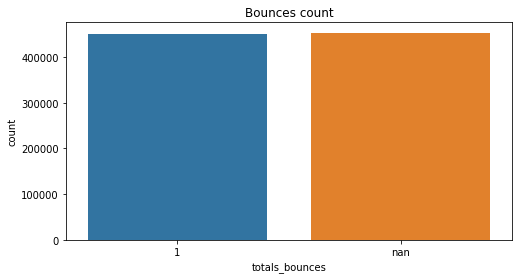

In [139]:
plt.figure(figsize=(8,4))
plt.title("Bounces count")
ax = sns.countplot(x='totals_bounces', data=train_df.fillna('nan'))

#### total_bounces can easily be removed from the data because it does not add any information to the model. 

In [140]:
train_df.totals_newVisits.unique()

array(['1', nan], dtype=object)

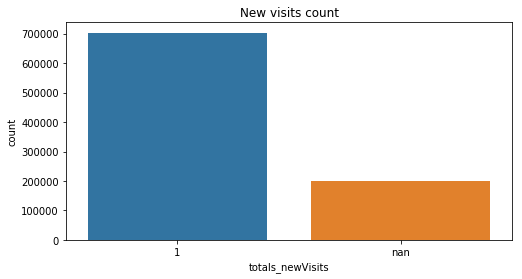

In [141]:
plt.figure(figsize=(8,4))
plt.title("New visits count")
ax = sns.countplot(x='totals_newVisits', data=train_df.fillna('nan'))

#### total_newVisits contains either 1 or nan. Therefore, it can be removed from the data.

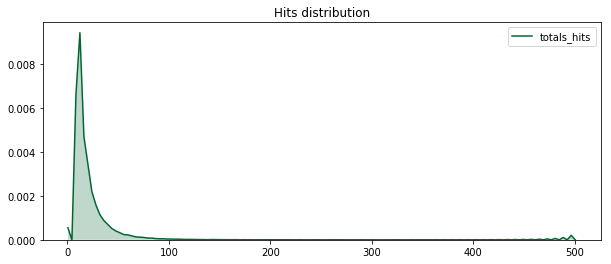

In [142]:
plt.figure(figsize=(10,4))
plt.title("Hits distribution")
ax1 = sns.kdeplot(train_df['totals_hits'].astype('float64'), color="#006633", shade=True)

#### The number of hits is mainly under 50 counts which is similar to the number of visits established previously.

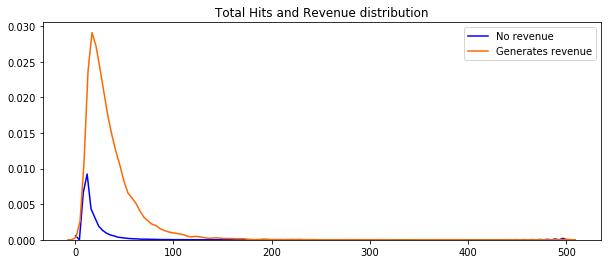

In [143]:
plt.figure(figsize=(10,4))
plt.title("Total Hits and Revenue distribution")
ax2 = sns.kdeplot(train_df[train_df['generates_revenue'] == 0]['totals_hits'].astype('float64'),
                  label='No revenue', color="#0000ff")
ax2 = sns.kdeplot(train_df[train_df['generates_revenue'] == 1]['totals_hits'].astype('float64'),
                  label='Generates revenue', color="#ff6600")

#### Revenue generating and zero_revenue hits both follow approximately the same pattern.

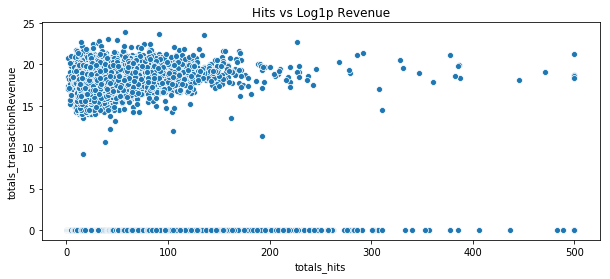

In [144]:
plt.figure(figsize=(10,4))
plt.title("Hits vs Log1p Revenue")
ax = sns.scatterplot(x=train_df['totals_hits'].astype('float64'), y=np.log1p(train_df['totals_transactionRevenue']))

#### The number of hits and the log of revenue approximately shape two parallel lines, one for zero revenue and one for the revenue between the range of 14-23. The main concentration of revenue making hits are bellow 100 hits. However, the relationship seems to be constant. 

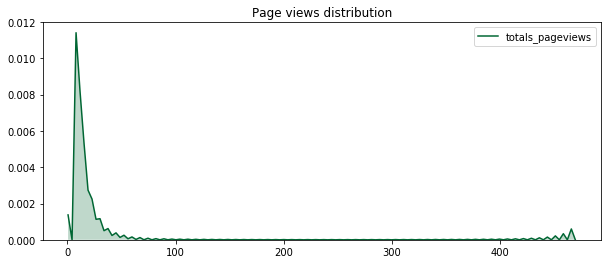

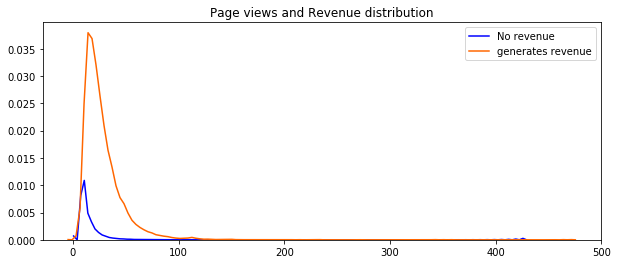

In [145]:
plt.figure(figsize=(10,4))
plt.title("Page views distribution")
ax3 = sns.kdeplot(train_df['totals_pageviews'].dropna().astype('float64'), color="#006633", shade=True)
plt.figure(figsize=(10,4))

plt.title("Page views and Revenue distribution")
ax4 = sns.kdeplot(train_df[train_df['generates_revenue'] == 0]['totals_pageviews'].dropna().astype('float64'),
                  label='No revenue', color="#0000ff")
ax4 = sns.kdeplot(train_df[train_df['generates_revenue'] == 1]['totals_pageviews'].dropna().astype('float64'),
                  label='generates revenue', color="#ff6600")

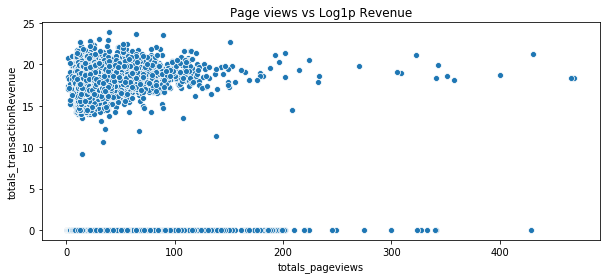

In [146]:
plt.figure(figsize=(10,4))
plt.title("Page views vs Log1p Revenue")
ax = sns.scatterplot(x=train_df['totals_pageviews'].dropna().astype('float64'), y=np.log1p(train_df['totals_transactionRevenue']))

#### Page view shows a similar pattern to hits both in terms of distribution and in terms of its relation to the total transaction revenue.

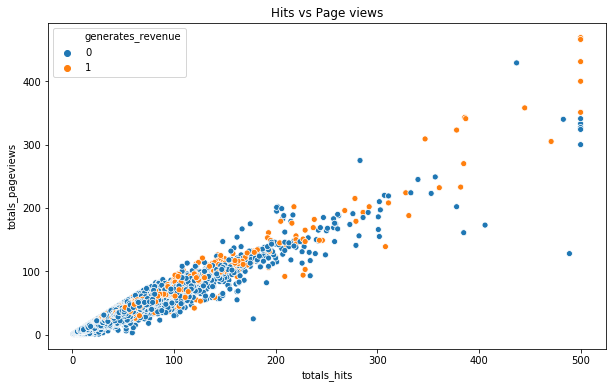

In [147]:
plt.figure(figsize=(10,6))
plt.title("Hits vs Page views")
tmp = train_df[['totals_hits', 'totals_pageviews', 'generates_revenue']].copy()
tmp['totals_hits'] = tmp['totals_hits'].astype('float64')
tmp['totals_pageviews'] = tmp['totals_pageviews'].dropna().astype('float64')
ax = sns.scatterplot(x='totals_hits', y='totals_pageviews', hue='generates_revenue', data=tmp)

#### totals_hits and totals_pageviews are highly correlated.  Two highly-correlated variables can be averaged to create a feature or one can be dropped. 

### Device

#### Device includes 4 features, namely: 

#### * device_browser: 54 categories
#### * device_operatingSystem: 20 categories
#### * device_deviceCategory: desktop, mobile or table
#### * device_isMobile: boolean column

In [148]:
def group_revenue(group_col, title, sum_values=True, palette='Blues_d', size=(8,5)):
    if sum_values:
        tmp = train_df.groupby(group_col)['totals_transactionRevenue'].sum()
    else:
        tmp = train_df.groupby(group_col)['totals_transactionRevenue'].mean()
    tmp = tmp.to_frame().reset_index().sort_values('totals_transactionRevenue', ascending=False)
    tmp = tmp[tmp['totals_transactionRevenue'] > 0]
    plt.figure(figsize=size)
    plt.title(title)
    ax = sns.barplot(y=tmp[group_col], x= tmp.totals_transactionRevenue, orient='h', palette=palette)

In [149]:
barplot_percentage('device_browser', num_bars= 7)

#### Chrome which is a Google browser is responsible for the major amount of visits. Safari comes the second. 

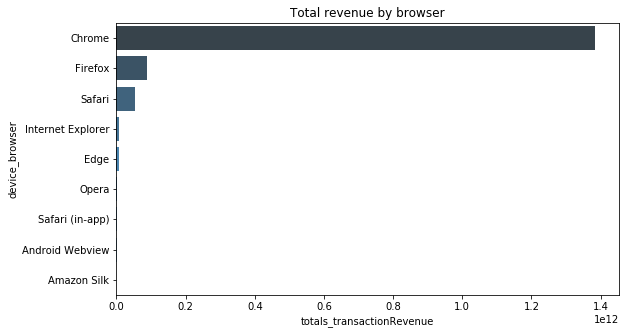

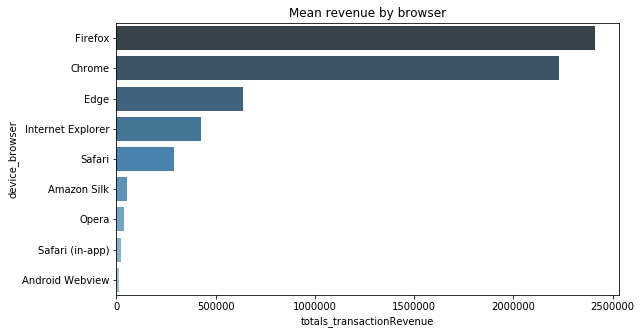

In [150]:
group_revenue('device_browser', 'Total revenue by browser', True, size=(9,5))
group_revenue('device_browser', 'Mean revenue by browser', False, 'Blues_d',size=(9,5))

#### In terms of revenue generation,  Chrome has is the number of browser. Looking at the mean revenue, Firefox and Chrome are both on top, indicating that most Firefox users are revenue generators.

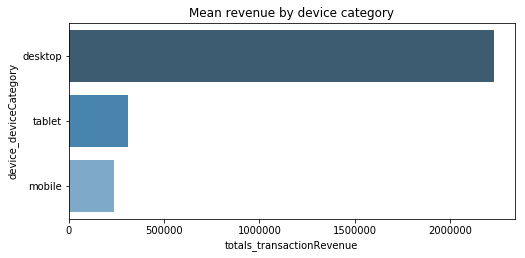

In [151]:
colors = ['#5c8a8a', '#94b8b8', '#b3cccc']
dev_train = train_df['device_deviceCategory'].value_counts().to_frame().reset_index()
dev_test = test_df['device_deviceCategory'].value_counts().to_frame().reset_index()
trace1 = go.Pie(labels=dev_train['index'], values=dev_train.device_deviceCategory,
                domain= {'x': [0, .48]}, marker=dict(colors=colors))
trace2 = go.Pie(labels=dev_test['index'], values=dev_test.device_deviceCategory,
                domain= {'x': [0.52, 1]}, marker=dict(colors=colors))
layout = dict(title= "Device category - train(left) and test(right)", height=400)
fig = dict(data=[trace1, trace2], layout=layout)
iplot(fig)

group_revenue('device_deviceCategory', 'Mean revenue by device category', False, 'Blues_d', size=(8, 3.6))

#### Most users use a desk top to visit GStore. Desktop also generates the highest number of visits. isMobile doesn't provide any additional information and can be removed. 

### Operating system

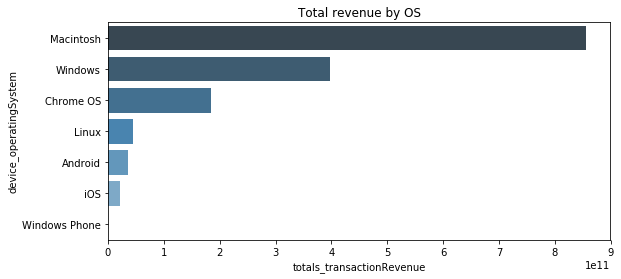

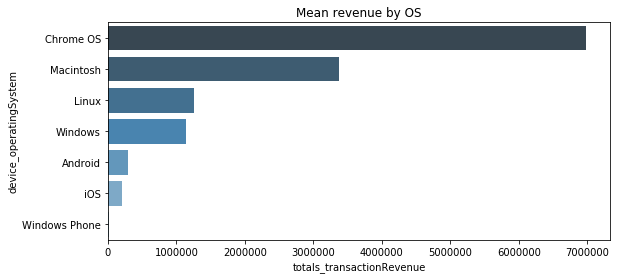

In [152]:
barplot_percentage('device_operatingSystem', num_bars = 7,
                   color1='rgb(204, 82, 0)', color2='rgb(255, 163, 102)')

group_revenue('device_operatingSystem', 'Total revenue by OS', True, 'Blues_d', size=(9, 4))
group_revenue('device_operatingSystem', 'Mean revenue by OS', False, 'Blues_d', size=(9, 4))

#### Windows, followed by Macintosh generate the highest number of visits.  Macintosh is the number one in generating revenue . Windows sits in second with less than a half of revenue compared to Macintosh.  Considering the mean of the revenue Chrome is at the first place.

### Traffic Source
#### There are 12 columns in this category with campaignCode feature were removed as only included one non missing value.

#### **Ads**

 1. adContent 
2. adNetworkType(AdWords related feature)
3. gclId :(It is an AdWords related feature. Gclid is a globally unique tracking parameter (Google Click Identifier) used by Google to pass information back and forth between Google AdWords and Google Analytics. )
4. isVideoAd: If the Ad is a video 
5.page
 6. slot

#### **Othere features**

7. campaign
8. isTrueDirect
9. keyword
10. medium
11. referralPath
12. source

#### Medium

In [153]:
def plotbar(df, col, title, top=None):
    frame = pd.DataFrame()
    frame['totals_transactionRevenue'] = df['totals_transactionRevenue'].copy()
    frame[col] = df[col].fillna('missing')
    # Percentage of revenue
    tmp_rev = frame.groupby(col)['totals_transactionRevenue'].sum().to_frame().reset_index()
    tmp_rev = tmp_rev.sort_values('totals_transactionRevenue', ascending=False)
    tmp_rev = tmp_rev.rename({'totals_transactionRevenue': 'Revenue percentage'},axis=1)
    tmp_rev['Revenue percentage'] = 100*tmp_rev['Revenue percentage']/df['totals_transactionRevenue'].sum()
    # Percentage of visits
    tmp = frame[col].value_counts().to_frame().reset_index()
    tmp.sort_values(col, ascending=False)
    tmp = tmp.rename({'index': col, col: 'Percentage of Visits'},axis=1)
    tmp['Percentage of Visits'] = 100*tmp['Percentage of Visits']/len(df)
    tmp = pd.merge(tmp, tmp_rev, on=col, how='left')
    if top:
        tmp = tmp.head(top)
    # Barplot
    trace1 = go.Bar(x=tmp[col], y=tmp['Percentage of Visits'],
                    name='Visits', marker=dict(color='rgb(55, 83, 109)'))
    trace2 = go.Bar(x=tmp[col], y=tmp['Revenue percentage'],
                    name='Revenue', marker=dict(color='rgb(26, 118, 255)'))
    layout = go.Layout(
        barmode='group',
        title=title,
    )
    
    layout = go.Layout(
        title=title,
        xaxis=dict(tickfont=dict(size=14, color='rgb(107, 107, 107)')),
        yaxis=dict(
            title='Percentage',
            titlefont=dict(size=16, color='rgb(107, 107, 107)'),
            tickfont=dict(size=14, color='rgb(107, 107, 107)')
        ),
        legend=dict(x=0.95, y=1.0, bgcolor='rgba(255, 255, 255, 0)',
                    bordercolor='rgba(255, 255, 255, 0)'),
        barmode='group',
        bargap=0.15,
        bargroupgap=0.1
    )
    
    fig = go.Figure(data=[trace1, trace2], layout=layout)
    iplot(fig)
    
plotbar(train_df, 'trafficSource_medium', 'Train set - visits and revenue by medium') 

 #### Organic medium has the highest number of visits. referall is the second in the number of visits but 1st in generating revenue.

### Interaction between 'trafficSource_source' and sub-categories of 'trafficSource_medium'

#### Organic

In [154]:
plotbar(train_df[train_df['trafficSource_medium'] == 'organic'], 'trafficSource_source', 'Visits and revenue by source for Organic search')

#### Looking closer at trafficSource_medium as organic and its interaction with trafficSource_source, we will see that google is the single source of visits when the medium is organic. 

### Interaction between 'trafficSource_medium' as organic and other features of trafficSource

In [155]:
def print_value_counts(category):
    cols = ['trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType',
           'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd',
           'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.slot',
           'trafficSource_referralPath', 'trafficSource_campaign']
    for c in cols:
        nunique = train_df[train_df['trafficSource_medium'] == category][c].nunique()
        if nunique < 5:
            print(train_df[train_df['trafficSource_medium'] == category][c].value_counts(dropna=False))
        else:
            print(train_df[train_df['trafficSource_medium'] == category][c].describe())
            
print_value_counts('organic')

NaN    381561
Name: trafficSource_adContent, dtype: int64
NaN    381561
Name: trafficSource_adwordsClickInfo.adNetworkType, dtype: int64
NaN    381561
Name: trafficSource_adwordsClickInfo.gclId, dtype: int64
True    381561
Name: trafficSource_adwordsClickInfo.isVideoAd, dtype: int64
NaN    381561
Name: trafficSource_adwordsClickInfo.page, dtype: int64
NaN    381561
Name: trafficSource_adwordsClickInfo.slot, dtype: int64
NaN    381561
Name: trafficSource_referralPath, dtype: int64
(not set)    381561
Name: trafficSource_campaign, dtype: int64


#### The above statistics showed that organic search which has the highest value among mediums for generating visits has no referralPath,  Ad variables  and all campaigns are '(not set)'.

#### Referals

In [156]:
plotbar(train_df[train_df['trafficSource_medium'] == 'referral'], 'trafficSource_source', 'Visits and revenue by source for Referral', top=10)

#### When the medium is referral, youtube generates most visits but it doesn't do well in generating revenue. On the other hand, mall.googleplex.com generate about 90% of revenue in referral medium.

In [157]:
print_value_counts('referral')

NaN    330955
Name: trafficSource_adContent, dtype: int64
NaN    330955
Name: trafficSource_adwordsClickInfo.adNetworkType, dtype: int64
NaN    330955
Name: trafficSource_adwordsClickInfo.gclId, dtype: int64
True    330955
Name: trafficSource_adwordsClickInfo.isVideoAd, dtype: int64
NaN    330955
Name: trafficSource_adwordsClickInfo.page, dtype: int64
NaN    330955
Name: trafficSource_adwordsClickInfo.slot, dtype: int64
count     330941
unique      1475
top            /
freq       75523
Name: trafficSource_referralPath, dtype: object
(not set)    330955
Name: trafficSource_campaign, dtype: int64


#### The above statistics showed that referall medium has all referral paths that are not missing, has no ad variables (all missing), all campaigns are '(not set)'. 

#### cpc
#### cpc is the medium for  google paid search result.

In [158]:
plotbar(train_df[train_df['trafficSource_medium'] == 'cpc'], 'trafficSource_source', 'Visits and revenue by source for CPC', top=None)

In [159]:
print_value_counts('cpc')

count                             10945
unique                               43
top       Google Merchandise Collection
freq                               5122
Name: trafficSource_adContent, dtype: object
Google Search      21453
NaN                 3866
Search partners        7
Name: trafficSource_adwordsClickInfo.adNetworkType, dtype: int64
count                                                 21561
unique                                                17774
top       Cj0KEQjwmIrJBRCRmJ_x7KDo-9oBEiQAuUPKMufMpuG3Zd...
freq                                                     70
Name: trafficSource_adwordsClickInfo.gclId, dtype: object
False    21460
True      3866
Name: trafficSource_adwordsClickInfo.isVideoAd, dtype: int64
count     21460
unique        8
top           1
freq      21362
Name: trafficSource_adwordsClickInfo.page, dtype: object
Top    20956
NaN     3866
RHS      504
Name: trafficSource_adwordsClickInfo.slot, dtype: int64
NaN    25326
Name: trafficSource_referralPath, dty

#### The above statistics showed that for cpc  Ad Network is mostly 'Google Search', referral path is mainly missing,  Campaign has very few missing values.

In [160]:
plotbar(train_df[train_df['trafficSource_medium'] == 'cpc'], 'trafficSource_campaign', 'Visits and revenue by campaign for CPC')

#### When the medium is cpc which is for google paid search result, AW-Dynamic search and AW- Accessories generate the highest amount of visits and revenue.

### User Analysis

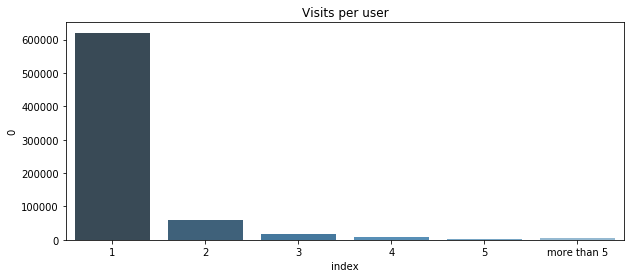

In [161]:
tmp = train_df.groupby('fullVisitorId').size().value_counts().to_frame().reset_index()
sum_ = tmp[tmp['index'].astype('int16') > 5][0].sum()
tmp = tmp.head(5).append(pd.DataFrame({'index': ['more than 5'], 0: [sum_]})).reset_index()
plt.figure(figsize=(10,4))
plt.title("Visits per user")
ax = sns.barplot(x=tmp['index'], y=tmp[0], palette='Blues_d')

#### Most users only make one visit to GStore.

### Removing columns created for EDA

In [162]:
train_df.drop(['month', 'day', 'generates_revenue'], axis=1, inplace=True)
test_df.drop(['month', 'day'], axis=1, inplace=True)

## Prepare Data for Model 

In [163]:
train_df= train_df.sort_values('date')
test_df=test_df.sort_values('date')
train_y = train_df["totals_transactionRevenue"].values
train_id = train_df["fullVisitorId"].values
test_id = test_df["fullVisitorId"].values

In [164]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device_browser', 'device_deviceCategory',
       'device_isMobile', 'device_operatingSystem', 'geoNetwork_city',
       'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro',
       'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_transactionRevenue',
       'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.isVideoAd',
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign',
       'trafficSource_isTrueDirect', 'trafficSource_keyword',
       'trafficSource_medium', 'trafficSource_referralPath',
       'trafficSource_source', 'country'],
      dtype='object')

### Encoding Categorical Variables

In [165]:
# categorical columns not needed.

train_df.drop(['device_isMobile', 'geoNetwork_country', 'geoNetwork_metro','geoNetwork_subContinent'], axis=1, inplace=True)
test_df.drop(['device_isMobile', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_subContinent'], axis=1, inplace=True)

cat_cols = ["channelGrouping", "device_browser", 
            "device_deviceCategory", "device_operatingSystem", 
            "trafficSource_adContent", 
            "trafficSource_adwordsClickInfo.adNetworkType", 
            "trafficSource_adwordsClickInfo.gclId", 
            "trafficSource_adwordsClickInfo.page", 
            "trafficSource_adwordsClickInfo.slot", "trafficSource_campaign",
            "trafficSource_keyword", "trafficSource_medium", 
            "trafficSource_referralPath", "trafficSource_source",
            'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_isTrueDirect', 'country','geoNetwork_city','geoNetwork_continent',
            'geoNetwork_networkDomain', 'geoNetwork_region']
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

channelGrouping
device_browser
device_deviceCategory
device_operatingSystem
trafficSource_adContent
trafficSource_adwordsClickInfo.adNetworkType
trafficSource_adwordsClickInfo.gclId
trafficSource_adwordsClickInfo.page
trafficSource_adwordsClickInfo.slot
trafficSource_campaign
trafficSource_keyword
trafficSource_medium
trafficSource_referralPath
trafficSource_source
trafficSource_adwordsClickInfo.isVideoAd
trafficSource_isTrueDirect
country
geoNetwork_city
geoNetwork_continent
geoNetwork_networkDomain
geoNetwork_region


### Numerical Variables

In [166]:
train_df.drop(['totals_bounces','totals_newVisits'], axis=1, inplace=True)
test_df.drop(['totals_bounces','totals_newVisits'], axis=1, inplace=True)
num_cols = ["totals_hits", "totals_pageviews", "visitNumber",'visitStartTime']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)
    train_df[col] = train_df[col].fillna(train_df[col].mean())
    test_df[col] = test_df[col].fillna(test_df[col].mean())

### Correlation Analysis

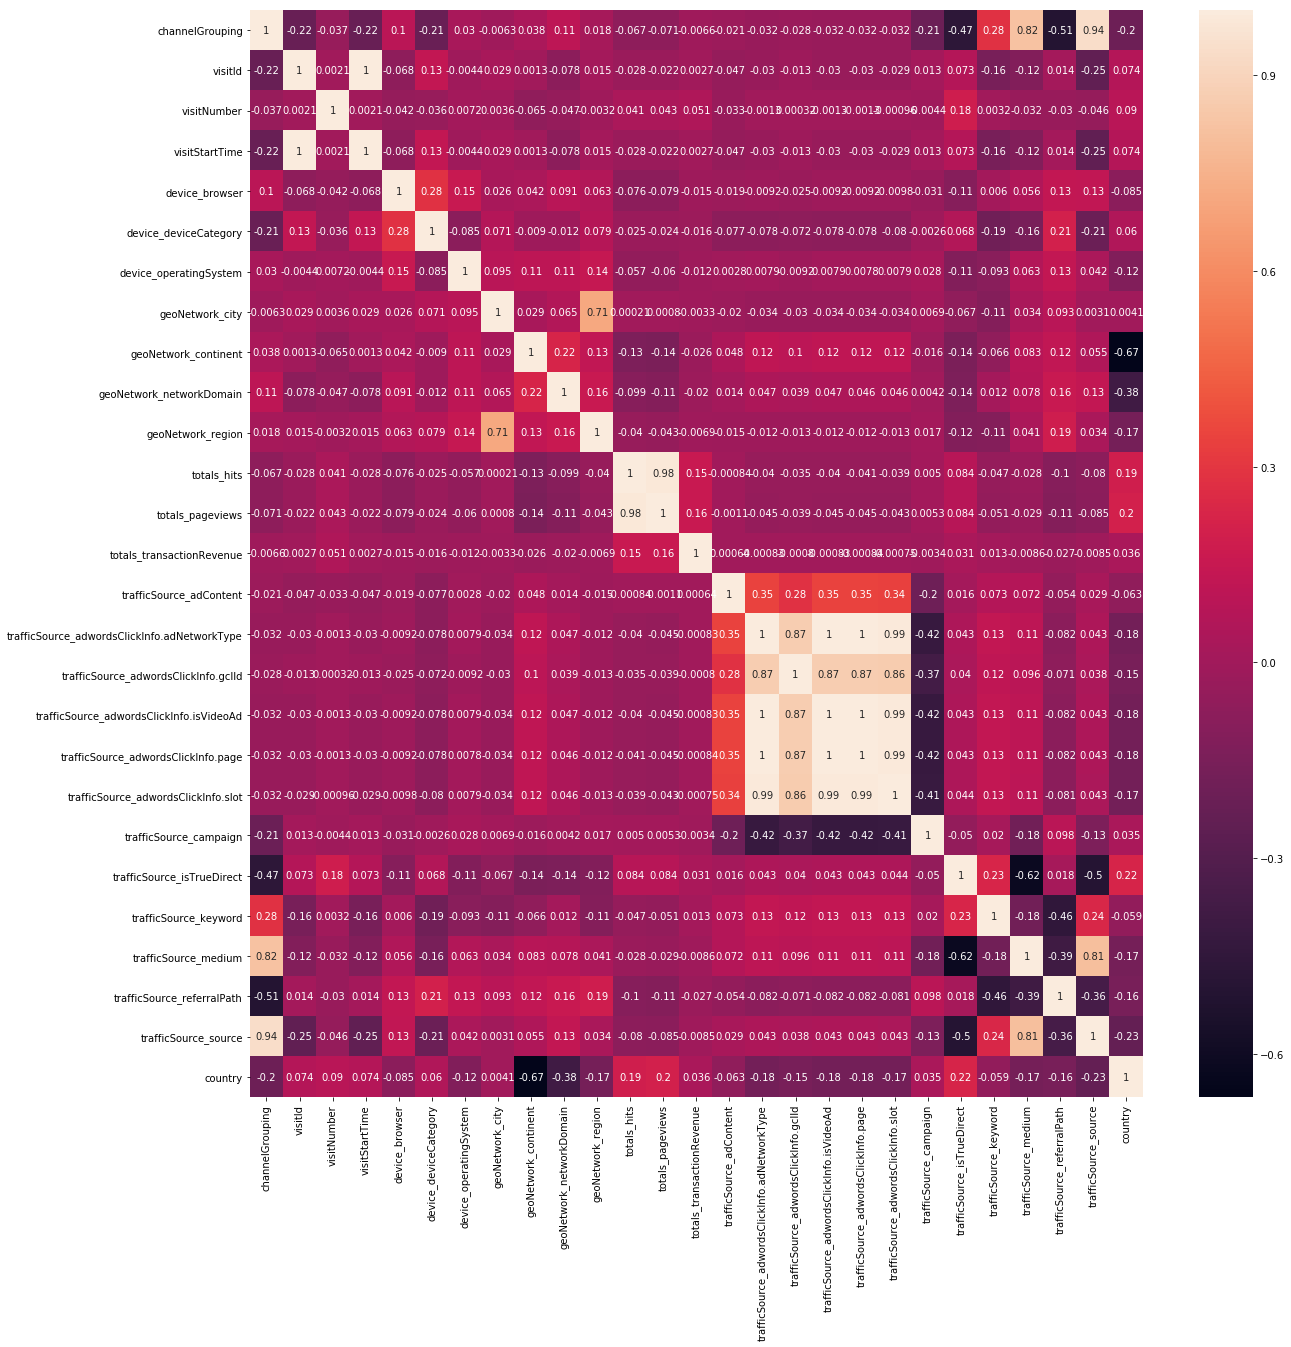

In [167]:
plt.figure(figsize=(20,20))
sns.heatmap(train_df.corr(),annot=True)

#### The above heatmap illustrates that the adwords related features are correlated. However, removing one of the correlated variables or averaging them have reduced the models' scores. These have been the case for the number of hits and page views. Therefore, we leave it to the models to handle the correlated variables. 

In [168]:
# Split the train dataset into development and valid based on time 
dev_df = train_df[train_df['date']<=datetime.date(2017,5,31)]
val_df = train_df[train_df['date']>datetime.date(2017,5,31)]
dev_y = np.log1p(dev_df["totals_transactionRevenue"].values)
val_y = np.log1p(val_df["totals_transactionRevenue"].values)

In [169]:
dev_X = dev_df[cat_cols + num_cols] 
val_X = val_df[cat_cols + num_cols] 
test_X = test_df[cat_cols + num_cols] 

In [170]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
dev_X = sc.fit_transform(dev_X)
val_X = sc.transform(val_X)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



 ## Random Forest

In [171]:
#import necessary libraries to build model
import random
from sklearn.ensemble import RandomForestRegressor
random.seed(42)
rf = RandomForestRegressor(n_estimators=10)
rf.fit(dev_X, dev_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [172]:
# Evaluation
from sklearn.metrics import mean_squared_error
pred=rf.predict(val_X)
score = np.sqrt(mean_squared_error(val_y,pred))
print (score)

1.8935737790275275


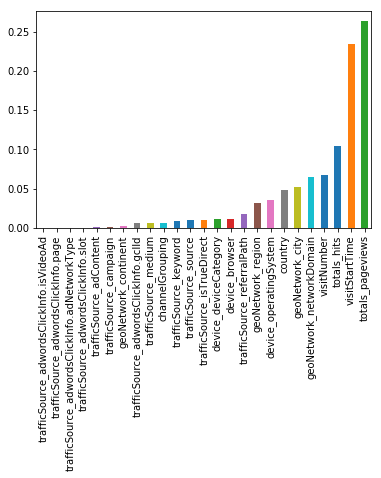

In [173]:
features= cat_cols + num_cols
pd.Series(index =features, data = rf.feature_importances_).sort_values().plot(kind = 'bar')

## Light GBM

In [174]:
%%time
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.69684
[200]	valid_0's rmse: 1.69246
[300]	valid_0's rmse: 1.6921
Early stopping, best iteration is:
[292]	valid_0's rmse: 1.69142
CPU times: user 40.5 s, sys: 512 ms, total: 41 s
Wall time: 20.9 s


### Feature Importance

Start training...


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning:

categorical_feature in Dataset is overridden. New categorical_feature is [23]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning:

categorical_feature in param dict is overridden.



[10]	training's rmse: 1.78848	valid_1's rmse: 1.91968
[20]	training's rmse: 1.69209	valid_1's rmse: 1.80529
[30]	training's rmse: 1.66417	valid_1's rmse: 1.77034
[40]	training's rmse: 1.6316	valid_1's rmse: 1.73469
[50]	training's rmse: 1.6195	valid_1's rmse: 1.72591
[60]	training's rmse: 1.609	valid_1's rmse: 1.71822
[70]	training's rmse: 1.60302	valid_1's rmse: 1.71476
[80]	training's rmse: 1.5971	valid_1's rmse: 1.711
[90]	training's rmse: 1.59254	valid_1's rmse: 1.70899
[100]	training's rmse: 1.58821	valid_1's rmse: 1.70721
Plot metrics recorded during training...


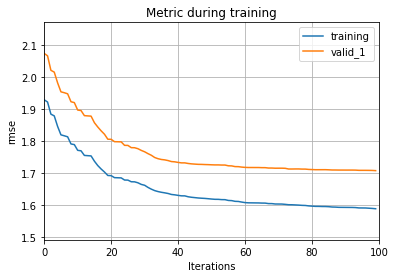

Plot feature importances...


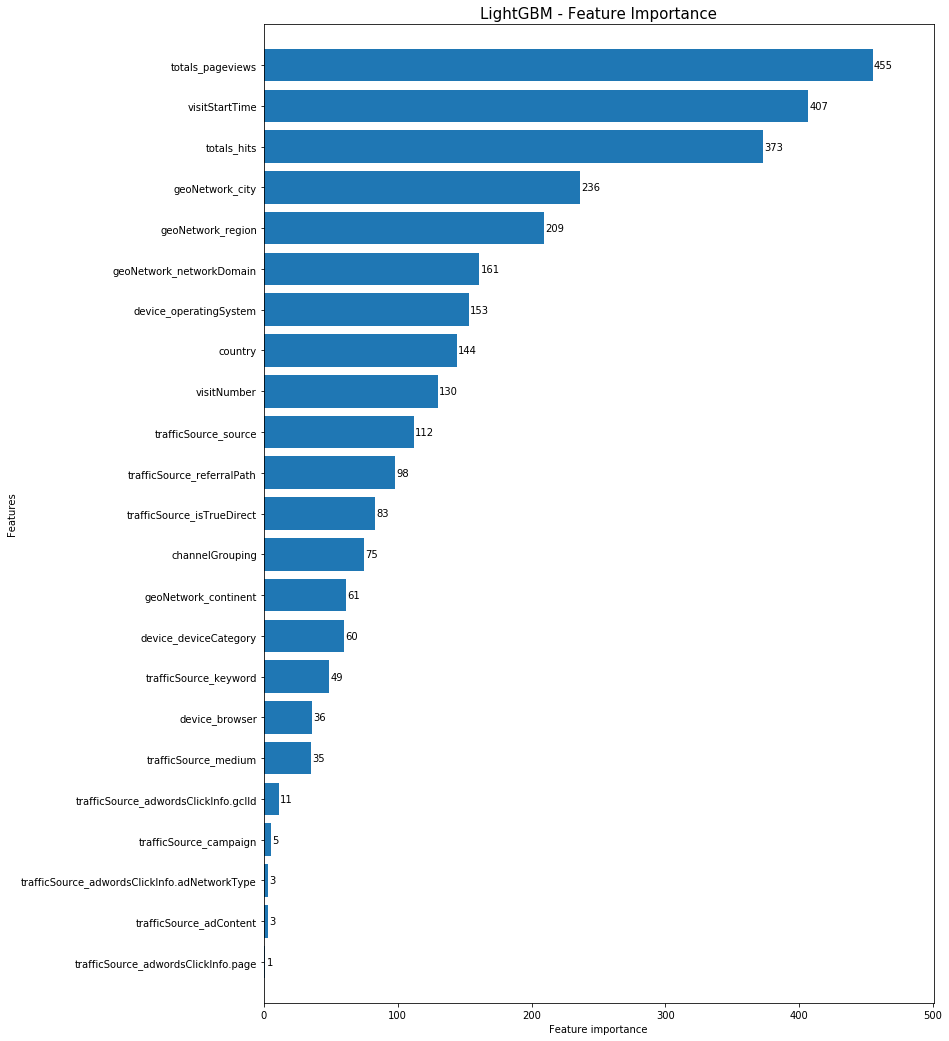

In [175]:
df_train = dev_df
df_test = val_df 

y_train = dev_y
y_test = val_y 
X_train = dev_X
X_test = val_X

   
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
}

evals_result = {}  # to record eval results for plotting

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=[lgb_train, lgb_test],
                feature_name=[feature for feature in features],
                categorical_feature=[23],
                evals_result=evals_result,
                verbose_eval=10)

print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()

print('Plot feature importances...')
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(gbm, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()


## Deep Learning Models (Keras)

### Sequential Model

In [176]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
# Define model
model = Sequential()
model.add(Dense(100, input_dim=25, activation= "relu"))
model.add(Dropout(0.1))
model.add(Dense(50, activation= "relu"))
model.add(Dropout(0.1))
model.add(Dense(1))
model.summary() #Print model Summary

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               2600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________


In [177]:
# Compile model
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])

In [178]:
# Fit Model
model.fit(dev_X, dev_y, epochs=40)

Epoch 1/40
765707/765707 [==============================] - 29s 38us/step - loss: 2.8422 - mean_squared_error: 2.8422
Epoch 2/40
765707/765707 [==============================] - 29s 37us/step - loss: 2.7534 - mean_squared_error: 2.7534
Epoch 3/40
765707/765707 [==============================] - 29s 37us/step - loss: 2.7409 - mean_squared_error: 2.7409
Epoch 4/40
765707/765707 [==============================] - 28s 37us/step - loss: 2.7244 - mean_squared_error: 2.7244
Epoch 5/40
765707/765707 [==============================] - 29s 37us/step - loss: 2.7174 - mean_squared_error: 2.7174
Epoch 6/40
765707/765707 [==============================] - 29s 38us/step - loss: 2.7114 - mean_squared_error: 2.7114
Epoch 7/40
765707/765707 [==============================] - 29s 38us/step - loss: 2.7032 - mean_squared_error: 2.7032
Epoch 8/40
765707/765707 [==============================] - 29s 38us/step - loss: 2.7012 - mean_squared_error: 2.7012
Epoch 9/40
765707/765707 [==============================

In [179]:
pred= model.predict(val_X)
score = np.sqrt(mean_squared_error(val_y,pred))
print (score)

1.7537311714744563


### Preparing data for models with K-fold cross_validation

In [180]:
train_df['totals_transactionRevenue'] = np.log1p(train_df['totals_transactionRevenue'])

In [181]:
X = train_df[cat_cols + num_cols] 
y = train_df['totals_transactionRevenue']
X_test = test_df[cat_cols + num_cols] 

### Light GBM with K-fold

In [182]:
# K-fold
params = {"objective" : "regression", "metric" : "rmse", "max_depth": 8, "min_child_samples": 20, "reg_alpha": 1, "reg_lambda": 1,'min_data_in_leaf': 20,
        "num_leaves" : 350, "learning_rate" : 0.01, "subsample" : 0.8, "colsample_bytree" : 0.85, "subsample_freq ": 5, "feature_fraction":0.95,
         "bagging_freq":1,"bagging_fraction":0.85 ,"bagging_seed": 32,"lambda_l1": 0.89}
folds = KFold(n_splits=10, shuffle=True, random_state=42)

In [183]:
NUM_ROUNDS = 20000
VERBOSE_EVAL = 500
STOP_ROUNDS = 100
model = lgb.LGBMRegressor(**params, n_estimators = NUM_ROUNDS, nthread = 4, n_jobs = -1)

prediction = np.zeros(test_df.shape[0])

for fold_n, (train_index, test_index) in enumerate(folds.split(X)):
    print('Fold:', fold_n)
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
            verbose=VERBOSE_EVAL, early_stopping_rounds=STOP_ROUNDS)
    
    y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
    prediction += y_pred
prediction /= 10

Fold: 0
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.53461	valid_1's rmse: 1.58145
Early stopping, best iteration is:
[701]	training's rmse: 1.51718	valid_1's rmse: 1.57997
Fold: 1
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.52737	valid_1's rmse: 1.64301
[1000]	training's rmse: 1.49016	valid_1's rmse: 1.63905
Early stopping, best iteration is:
[1143]	training's rmse: 1.48247	valid_1's rmse: 1.63881
Fold: 2
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.53018	valid_1's rmse: 1.60308
Early stopping, best iteration is:
[874]	training's rmse: 1.50265	valid_1's rmse: 1.60195
Fold: 3
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.52884	valid_1's rmse: 1.61855
[1000]	training's rmse: 1.49117	valid_1's rmse: 1.61584
Early stopping, best iteration is:
[998]	training's rmse: 1.49129	valid_1's rmse: 1.61581
Fold: 4
Training until 

#### Feature Importance

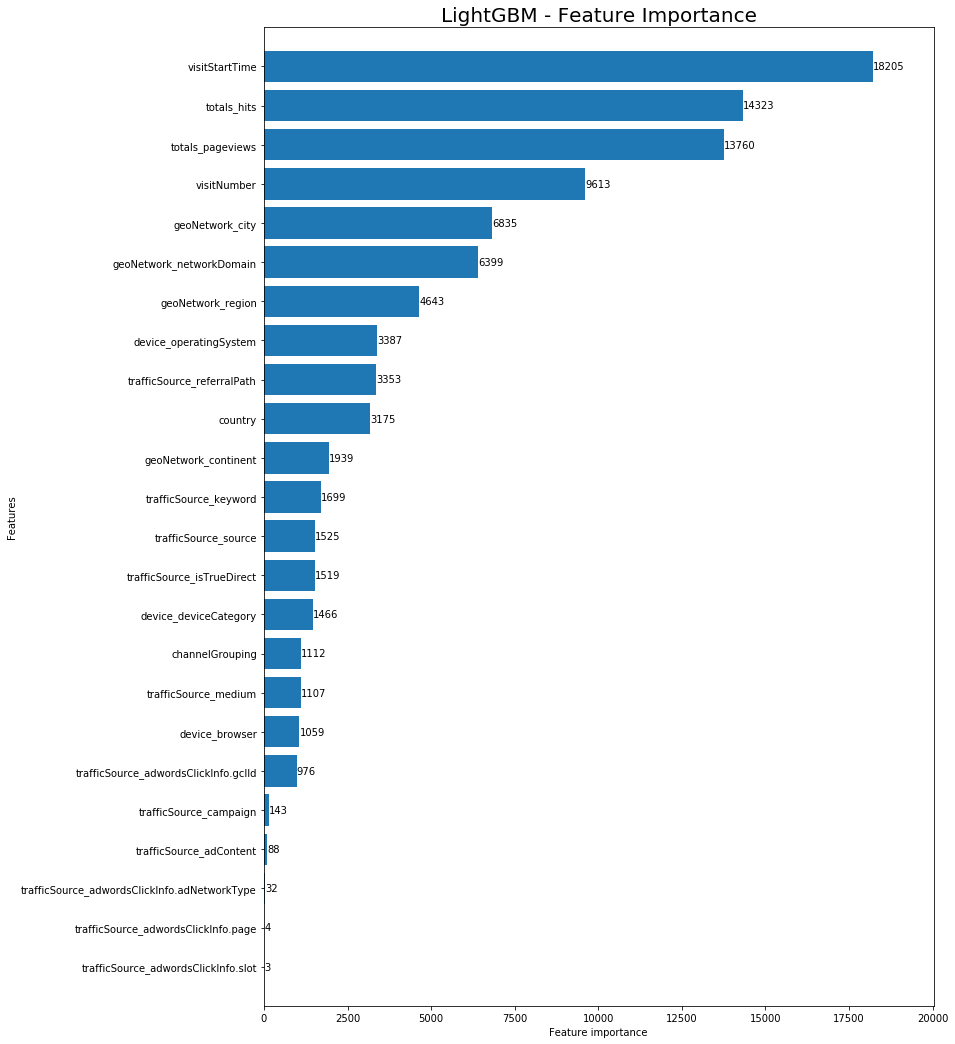

In [184]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=20)
plt.show()

### XGB Model

In [185]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
folds1 = KFold(n_splits=10, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=1)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test (submit) shape: {X_test.shape}")

Train shape: (768105, 25)
Validation shape: (135548, 25)
Test (submit) shape: (804684, 25)


In [186]:
#params1 = {'objective': 'reg:linear',
          #'eval_metric': 'rmse',
          #'eta': 0.001,
          #'max_depth': 10,
          #'subsample': 0.6,
          #'colsample_bytree': 0.8,
          #'alpha':0.001,
          #"num_leaves" : 12**2,
          # 'random_state': 42,
          # 'silent': True,
          #}

#prediction = np.zeros(test_df.shape[0])

#for fold_n1, (train_index, test_index) in enumerate(folds1.split(X)):
    #print('Fold:', fold_n1)
    #xgb_train_data = xgb.DMatrix(X_train, y_train)
    #xgb_val_data = xgb.DMatrix(X_val, y_val)
    #xgb_submit_data = xgb.DMatrix(X_test)

    #model = xgb.train(params1, xgb_train_data, 
                      #num_boost_round=2000, 
                      #evals= [(xgb_train_data, 'train'), (xgb_val_data, 'valid')],
                      #early_stopping_rounds=70, 
                      #verbose_eval=500
                     #)
#y_pred = model.predict(xgb_submit_data, ntree_limit=model.best_ntree_limit)
#prediction += y_pred
#prediction /= 10

Fold: 0

[0]	train-rmse:2.02793	valid-rmse:1.98447

Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 70 rounds.

[500]	train-rmse:1.77236	valid-rmse:1.77246

[1000]	train-rmse:1.63501	valid-rmse:1.67733

[1500]	train-rmse:1.55657	valid-rmse:1.6356

[1999]	train-rmse:1.505	valid-rmse:1.61689

Fold: 1

[0]	train-rmse:2.02793	valid-rmse:1.98447

Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.


Will train until valid-rmse hasn't improved in 70 rounds.

[500]	train-rmse:1.77236	valid-rmse:1.77246

[1000]	train-rmse:1.63501	valid-rmse:1.67733

[1500]	train-rmse:1.55657	valid-rmse:1.6356

[1999]	train-rmse:1.505	valid-rmse:1.61689

Fold: 2

[0]	train-rmse:2.02793	valid-rmse:1.98447

Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.


Will train until valid-rmse hasn't improved in 70 rounds.

[500]	train-rmse:1.77236	valid-rmse:1.77246

[1000]	train-rmse:1.63501	valid-rmse:1.67733

[1500]	train-rmse:1.55657	valid-rmse:1.6356

[1999]	train-rmse:1.505	valid-rmse:1.61689

Fold: 3

[0]	train-rmse:2.02793	valid-rmse:1.98447

Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.


Will train until valid-rmse hasn't improved in 70 rounds.

[500]	train-rmse:1.77236	valid-rmse:1.77246

[1000]	train-rmse:1.63501	valid-rmse:1.67733

[1500]	train-rmse:1.55657	valid-rmse:1.6356

[1999]	train-rmse:1.505	valid-rmse:1.61689

Fold: 4

[0]	train-rmse:2.02793	valid-rmse:1.98447

Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.


Will train until valid-rmse hasn't improved in 70 rounds.

[500]	train-rmse:1.77236	valid-rmse:1.77246

[1000]	train-rmse:1.63501	valid-rmse:1.67733

[1500]	train-rmse:1.55657	valid-rmse:1.6356

[1999]	train-rmse:1.505	valid-rmse:1.61689

Fold: 5

[0]	train-rmse:2.02793	valid-rmse:1.98447

Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.


Will train until valid-rmse hasn't improved in 70 rounds.

[500]	train-rmse:1.77236	valid-rmse:1.77246

[1000]	train-rmse:1.63501	valid-rmse:1.67733

[1500]	train-rmse:1.55657	valid-rmse:1.6356

[1999]	train-rmse:1.505	valid-rmse:1.61689


Fold: 6

[0]	train-rmse:2.02793	valid-rmse:1.98447

Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.


Will train until valid-rmse hasn't improved in 70 rounds.

[500]	train-rmse:1.77236	valid-rmse:1.77246

[1000]	train-rmse:1.63501	valid-rmse:1.67733

[1500]	train-rmse:1.55657	valid-rmse:1.6356

[1999]	train-rmse:1.505	valid-rmse:1.61689

Fold: 7

[0]	train-rmse:2.02793	valid-rmse:1.98447

Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.


Will train until valid-rmse hasn't improved in 70 rounds.

[500]	train-rmse:1.77236	valid-rmse:1.77246

[1000]	train-rmse:1.63501	valid-rmse:1.67733

[1500]	train-rmse:1.55657	valid-rmse:1.6356

[1999]	train-rmse:1.505	valid-rmse:1.61689

Fold: 8

[0]	train-rmse:2.02793	valid-rmse:1.98447

Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.


Will train until valid-rmse hasn't improved in 70 rounds.

[500]	train-rmse:1.77236	valid-rmse:1.77246

[1000]	train-rmse:1.63501	valid-rmse:1.67733

[1500]	train-rmse:1.55657	valid-rmse:1.6356

[1999]	train-rmse:1.505	valid-rmse:1.61689

Fold: 9

[0]	train-rmse:2.02793	valid-rmse:1.98447

Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.


Will train until valid-rmse hasn't improved in 70 rounds.

[500]	train-rmse:1.77236	valid-rmse:1.77246

[1000]	train-rmse:1.63501	valid-rmse:1.67733

[1500]	train-rmse:1.55657	valid-rmse:1.6356

[1999]	train-rmse:1.505	valid-rmse:1.61689


### Feature Importance

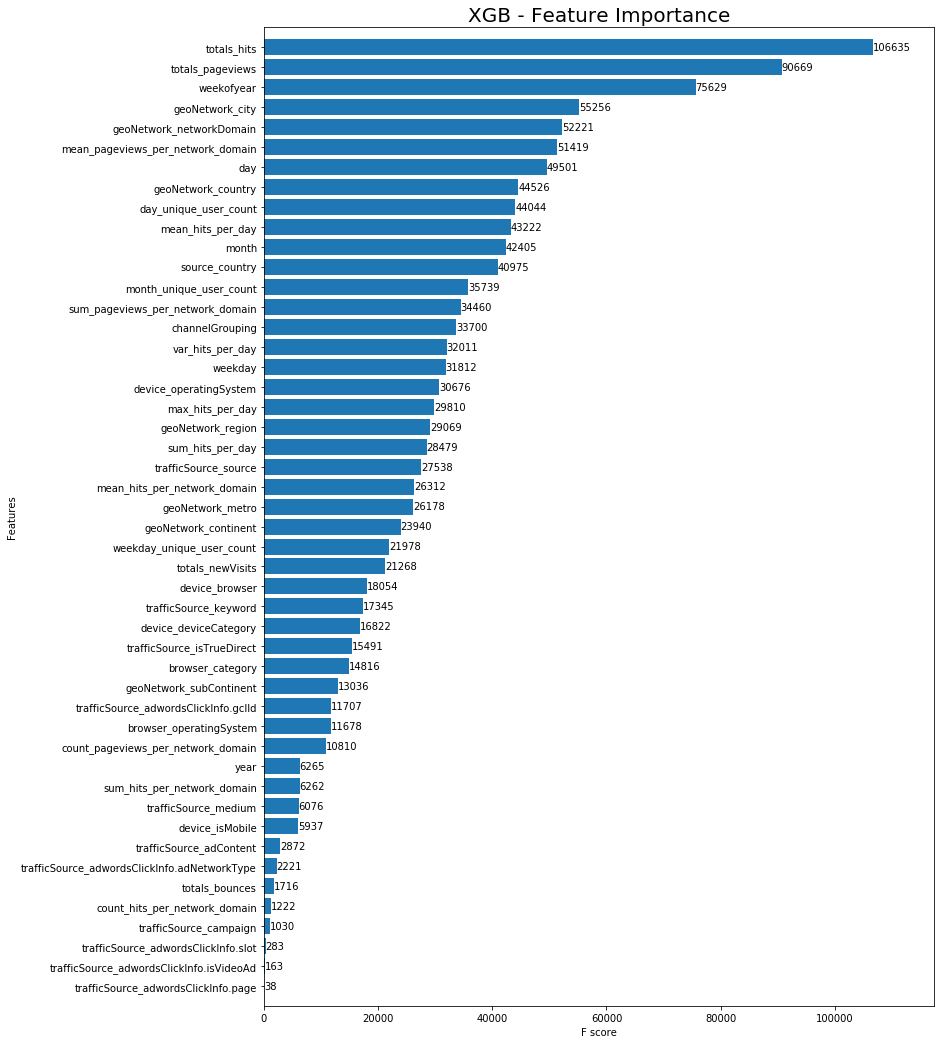

### Catboost Model

In [187]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
folds2 = KFold(n_splits=10, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=1)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test (submit) shape: {X_test.shape}")

Train shape: (768105, 25)
Validation shape: (135548, 25)
Test (submit) shape: (804684, 25)


In [188]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 5)


prediction = np.zeros(test_df.shape[0])
model = CatBoostRegressor(iterations=1000,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)

for fold_n2, (train_index, test_index) in enumerate(folds2.split(X)):
    print('Fold:', fold_n2)
    model.fit(X_train, y_train,eval_set=(X_val, y_val),use_best_model=True,verbose=True)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_submit = model.predict(X_test)
    print(f"CatB: RMSE val: {rmse(y_val, y_pred_val)}  - RMSE train: {rmse(y_train, y_pred_train)}")
    
y_pred_submit = model.predict(X_test)
prediction += y_pred_submit
prediction /= 10

Fold: 0
0:	learn: 1.9928813	test: 1.9478049	best: 1.9478049 (0)	total: 239ms	remaining: 3m 58s
50:	learn: 1.6384414	test: 1.6247499	best: 1.6247499 (50)	total: 9.02s	remaining: 2m 47s
100:	learn: 1.6046729	test: 1.6106488	best: 1.6106488 (100)	total: 17.4s	remaining: 2m 35s
150:	learn: 1.5837968	test: 1.6047710	best: 1.6047710 (150)	total: 25.5s	remaining: 2m 23s
200:	learn: 1.5646238	test: 1.6019013	best: 1.6019013 (200)	total: 33.6s	remaining: 2m 13s
250:	learn: 1.5481908	test: 1.5985661	best: 1.5984848 (247)	total: 41.8s	remaining: 2m 4s
300:	learn: 1.5342578	test: 1.5968659	best: 1.5968380 (299)	total: 50.2s	remaining: 1m 56s
350:	learn: 1.5199769	test: 1.5949080	best: 1.5949080 (350)	total: 58.6s	remaining: 1m 48s
400:	learn: 1.5080855	test: 1.5946346	best: 1.5946346 (400)	total: 1m 6s	remaining: 1m 39s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1.59457756
bestIteration = 402

Shrink model to first 403 iterations.
CatB: RMSE val: 1.59458  - RMSE train: 1.507

50:	learn: 1.6384414	test: 1.6247499	best: 1.6247499 (50)	total: 8.85s	remaining: 2m 44s
100:	learn: 1.6046729	test: 1.6106488	best: 1.6106488 (100)	total: 17.2s	remaining: 2m 33s
150:	learn: 1.5837968	test: 1.6047710	best: 1.6047710 (150)	total: 25.4s	remaining: 2m 22s
200:	learn: 1.5646238	test: 1.6019013	best: 1.6019013 (200)	total: 33.9s	remaining: 2m 14s
250:	learn: 1.5481908	test: 1.5985661	best: 1.5984848 (247)	total: 42s	remaining: 2m 5s
300:	learn: 1.5342578	test: 1.5968659	best: 1.5968380 (299)	total: 50.3s	remaining: 1m 56s
350:	learn: 1.5199769	test: 1.5949080	best: 1.5949080 (350)	total: 58.7s	remaining: 1m 48s
400:	learn: 1.5080855	test: 1.5946346	best: 1.5946346 (400)	total: 1m 7s	remaining: 1m 40s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1.59457756
bestIteration = 402

Shrink model to first 403 iterations.
CatB: RMSE val: 1.59458  - RMSE train: 1.50781
Fold: 8
0:	learn: 1.9928813	test: 1.9478049	best: 1.9478049 (0)	total: 177ms	remaining: 2m 56s

## Result

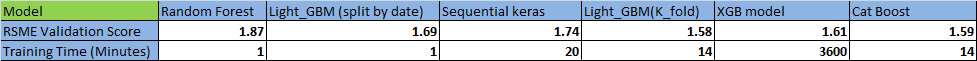

#### For evaluating model, we should look into the performance of model in terms of both speed and accuracy.  In this project, the best place goes to Light GBM with k-fold cross validation. An important thing to note  is that it performed well in terms of both speed and accuracy. (LGBM(K-fold) — 1.58, speed-14 minutes).

#### CatBoost comes out at the second with the accuracy of 1.59 and training time of about 14  minutes.  CatBoost performs well  when we have categorical variables in the data and we properly tune them.

#### Our next performer was XGBoost. It’s accuracy was quite close to CatBoost even after ignoring the fact that we have categorical variables in the data which we had converted into numerical values for its consumption. However, the main problem with XGBoost is that it is too slow. It took about  6 hours to train the model and get predictions.

#### Light GBM split by date comes next with score of 1.69 and less than a minute running time. The RSME  training score for this model is 1.59. The difference between training and test score indicates overfitting. Running the model for few extra minutes for K-fold cross-validation definitely worthy of overcoming this issue. 

#### Sequential Keras is the last model with validation score of 1.71. It seems boosted tree based models perform better than neural nets on this data.

## Conclusion

#### The objective of this project was to build a model to predict how much visitors of GStore will spend. This objective was selected based on a prevailing concept in business that most amount of revenue comes from a small percentage of customers (80/20 rule).  Identification of that small percentage of the customers could assist the marketing department to focus its efforts and mange its resources more efficiently. The best performed model in this project was light gbm with fast speed, maximum accuracy and least over fitting with the Root Mean Square Error (RMSE) of 1.58 on the test data. 

#### In order to improve the performance of the model, feature engineering proved to be useful. However, the amount of improvement compared to the time spent is something that needs to be considered. 

#### The Sequential model performed poorly in this case. Adding more layers and considering other deep learning models such as Time Series RNN could be useful.


#### Acknowledgment

#### I would like to express my thanks to  Kaggle community for the inspiring projects they have done on this dataset.
